In [1]:
from common import *

In [2]:
data = pd.read_csv('common/data/earthquake_data.csv')
R = 63710

lat_rad = np.radians(data['latitude'])
lon_rad = np.radians(data['longitude'])
r = R - data['depth']

data['x'] = r * np.cos(lat_rad) * np.cos(lon_rad)
data['y'] = r * np.cos(lat_rad) * np.sin(lon_rad)
data['z'] = r * np.sin(lat_rad)
X = data[['x','y','z']].values

In [3]:
import numpy as np
from sklearn.cluster import SpectralClustering
from sklearn.preprocessing import StandardScaler
from sklearn.neighbors import kneighbors_graph
from sklearn.metrics.pairwise import rbf_kernel

# 1. Scaling
scaler = StandardScaler()
coords = data[['x', 'y', 'z']].values
mag_scaled = scaler.fit_transform(data[['mag']])

# 2. Build Spatial Connectivity
# We keep 7 because it found your high-magnitude "core"
adj_binary = kneighbors_graph(coords, n_neighbors=7, mode='connectivity').toarray()

# 3. Build Attribute Similarity (Magnitude)
mag_similarity = rbf_kernel(mag_scaled, gamma=1.0)

# 4. Create Weighted Adjacency Matrix with "Soft Connectivity"
# Multiply to enforce the spatial constraint
adj_weighted = adj_binary * mag_similarity

# --- NEW: Fix for "Not Fully Connected" Warning ---
# We add a tiny amount of global connectivity (1e-5) 
# This keeps the graph connected without changing the results
adj_weighted = adj_weighted + (1e-5 * mag_similarity)

# Ensure symmetry
adj_weighted = (adj_weighted + adj_weighted.T) / 2

# 5. Run Spectral Clustering
# Using 'discretize' as you did—it's more stable for spatial data
spectral = SpectralClustering(n_clusters=4, 
                              affinity='precomputed', 
                              assign_labels='discretize', 
                              random_state=42)

data['spectral_cluster'] = spectral.fit_predict(adj_weighted)

In [4]:

from sklearn.cluster import KMeans
# 1. Select ONLY the relevant columns
features = ['latitude', 'longitude', 'mag']
cluster_data = data[features]

# 2. Handle missing values (if any) in these specific columns
cluster_data = cluster_data.dropna()

# 3. Scale the data 
# This is vital because coordinates and magnitude are on different scales!
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
scaled_features = scaler.fit_transform(cluster_data)




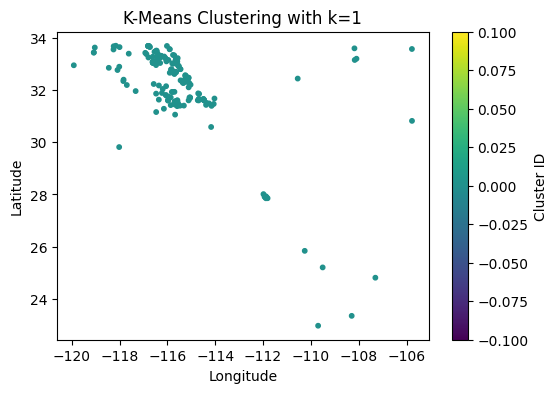

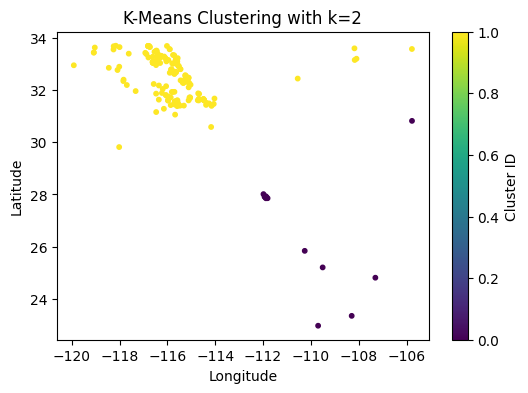

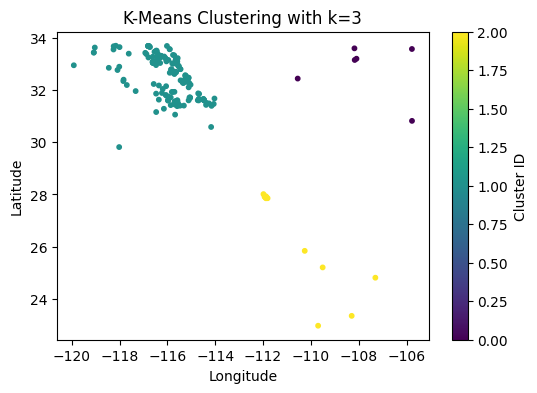

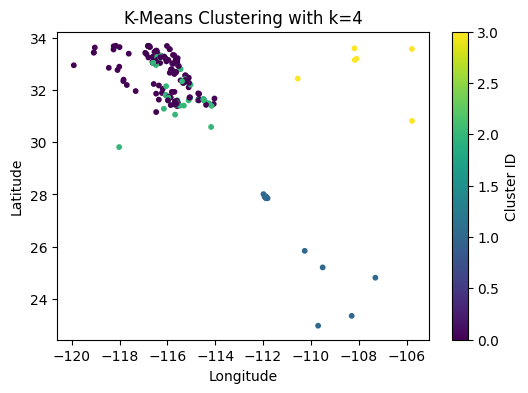

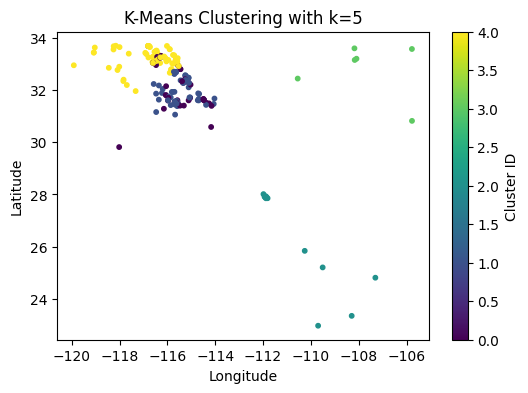

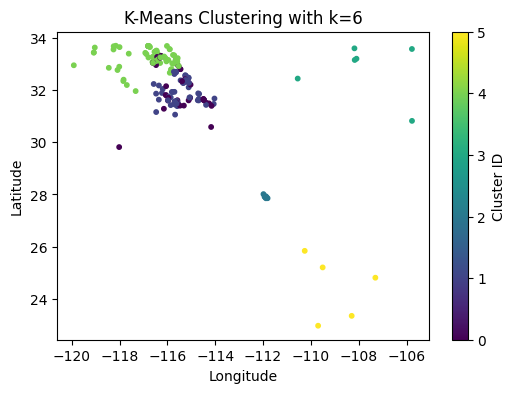

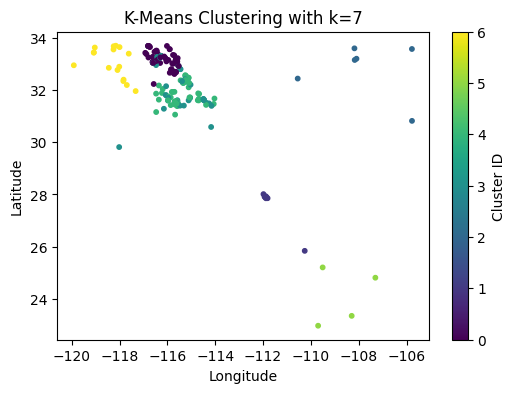

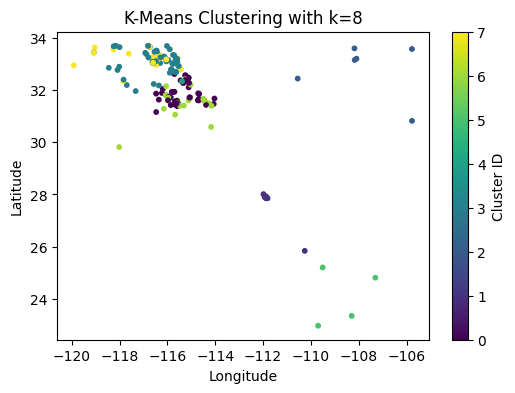

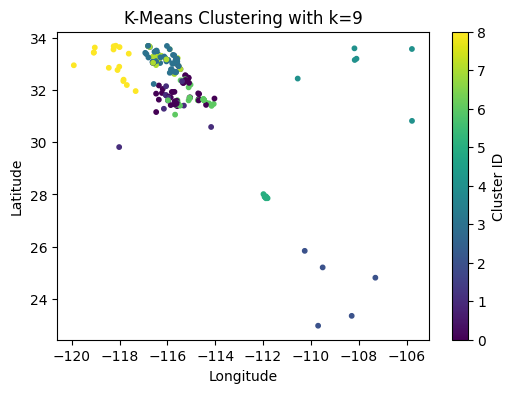

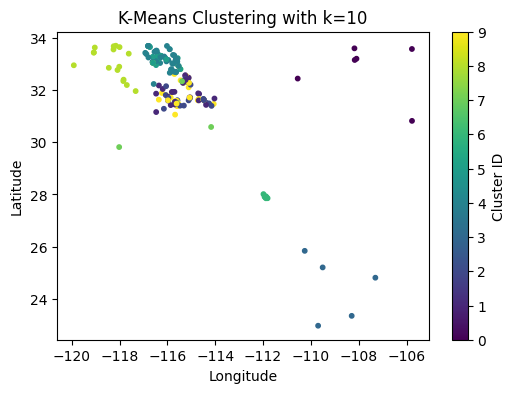

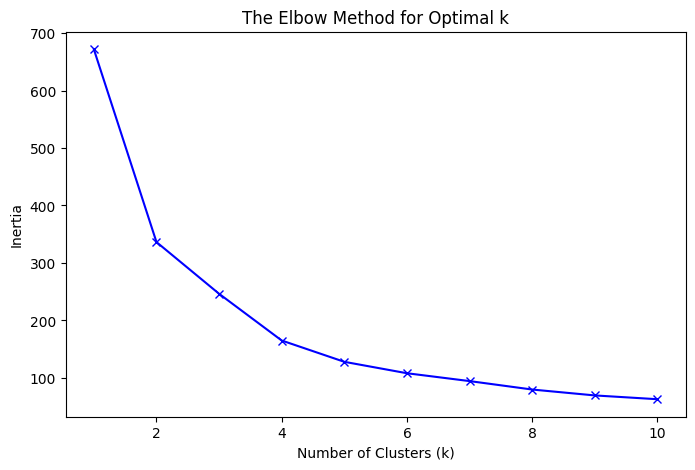

In [5]:
plot_elbow_method(data, scaled_features)

In [47]:
print(data['spectral_cluster'].value_counts())

spectral_cluster
0    99
3    87
1    25
2    13
Name: count, dtype: int64


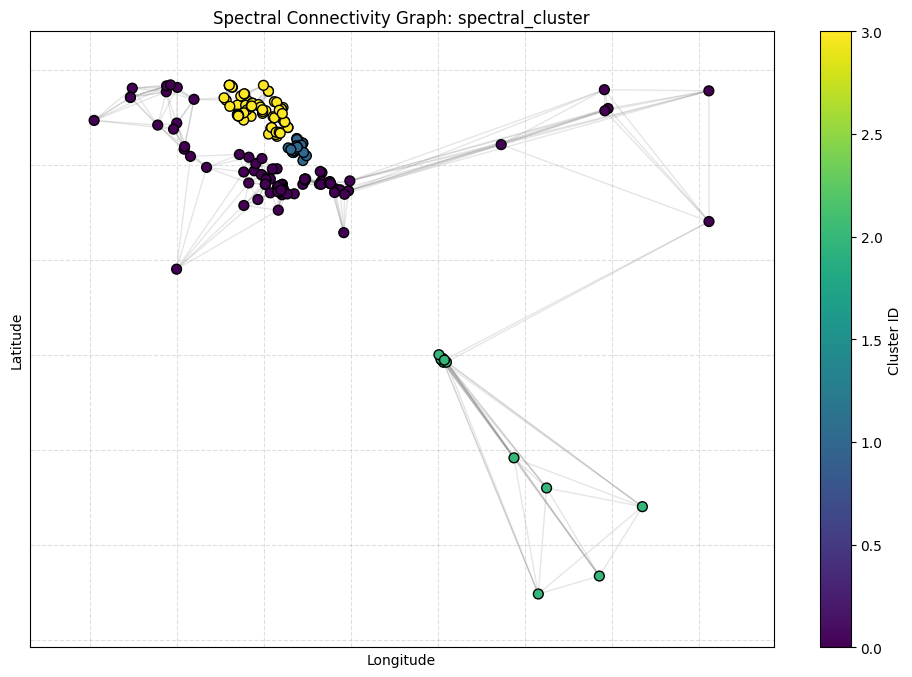

In [55]:
visualize_graph_connectivity(data, adj_binary, 'spectral_cluster')

In [49]:
visualize_3d(data, 'spectral_cluster')

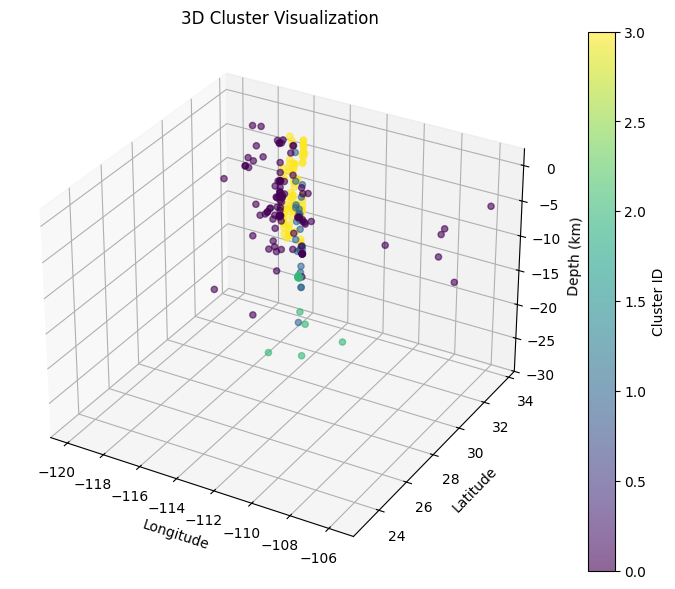

In [50]:
visualize_3d_static(data, 'spectral_cluster')

In [51]:
calculate_sillouette_score(adj_weighted, 'spectral_cluster', data)

Silhouette Score: 0.024246850536804414


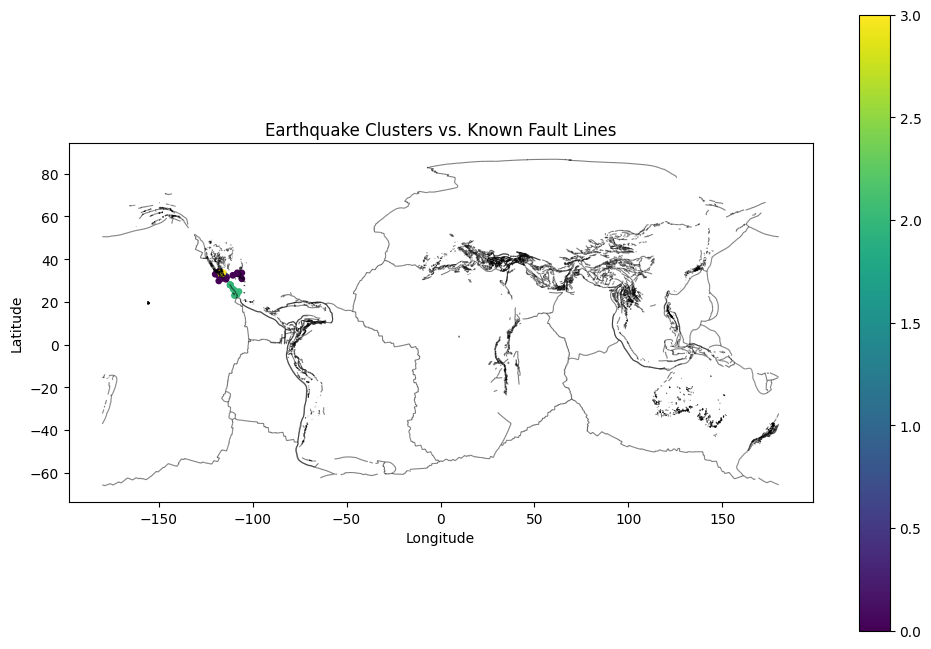

In [41]:
visualize_clusters_on_known_fault_lines(data, crs="EPSG:4326", cluster_column='spectral_cluster')

/var/folders/bz/yzqc11sn1gj3p_f45_fhc_qc0000gn/T/ipykernel_1184/473461042.py:6: FutureWarning:



Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.




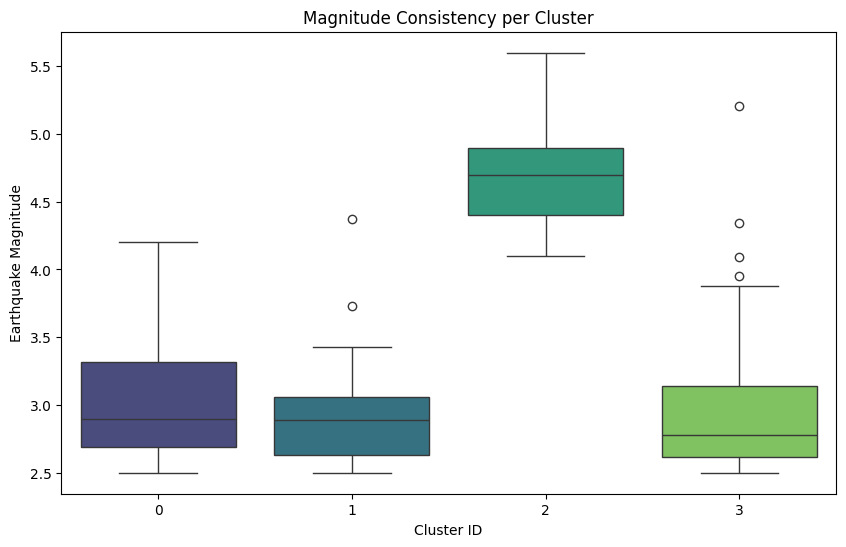

                      mean       std  count  coefficient_of_variation
spectral_cluster                                                     
0                 3.011315  0.421843     99                  0.140086
1                 2.962000  0.441484     25                  0.149049
2                 4.684615  0.448788     13                  0.095800
3                 2.954672  0.468441     87                  0.158543


In [52]:
import seaborn as sns
import matplotlib.pyplot as plt

# 1. Box plot to check consistency
plt.figure(figsize=(10,6))
sns.boxplot(x='spectral_cluster', y='mag', data=data, palette='viridis')
plt.title('Magnitude Consistency per Cluster')
plt.xlabel('Cluster ID')
plt.ylabel('Earthquake Magnitude')
plt.show()

# 2. Summary Table
stats = data.groupby('spectral_cluster')['mag'].agg(['mean', 'std', 'count'])
stats['coefficient_of_variation'] = stats['std'] / stats['mean']
print(stats)

In [53]:
# Calculate the center point for each cluster
cluster_stats = data.groupby('spectral_cluster').agg({
    'x': 'mean',
    'y': 'mean',
    'z': 'mean',
    'mag': ['mean', 'count']
}).reset_index()

# Flatten columns for readability
cluster_stats.columns = ['Cluster', 'Avg_X', 'Avg_Y', 'Avg_Z', 'Avg_Mag', 'Count']

print("--- Cluster Geographic Centers ---")
print(cluster_stats)

# Quick check: Calculate the distance between the centers of Cluster 1 and 3
import numpy as np
c1 = cluster_stats.loc[cluster_stats['Cluster'] == 1, ['Avg_X', 'Avg_Y', 'Avg_Z']].values
c3 = cluster_stats.loc[cluster_stats['Cluster'] == 3, ['Avg_X', 'Avg_Y', 'Avg_Z']].values
dist = np.linalg.norm(c1 - c3)

print(f"\nDistance between Cluster 1 and Cluster 3 centers: {dist:.2f}")

--- Cluster Geographic Centers ---
   Cluster         Avg_X         Avg_Y         Avg_Z   Avg_Mag  Count
0        0 -23201.188960 -48808.920685  33640.575200  3.011315     99
1        1 -22924.667568 -48667.675225  34104.323380  2.962000     25
2        2 -20181.095425 -53223.437075  28481.459877  4.684615     13
3        3 -23508.612373 -47851.507817  34856.865098  2.954672     87

Distance between Cluster 1 and Cluster 3 centers: 1254.37


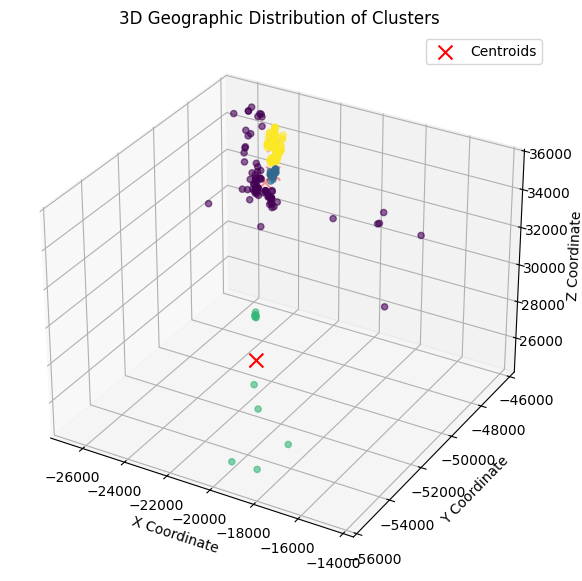

In [54]:
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

fig = plt.figure(figsize=(10, 7))
ax = fig.add_subplot(111, projection='3d')

# Scatter plot of all points colored by cluster
scatter = ax.scatter(data['x'], data['y'], data['z'], 
                     c=data['spectral_cluster'], cmap='viridis', s=20, alpha=0.6)

# Mark the centroids with a red 'X'
ax.scatter(cluster_stats['Avg_X'], cluster_stats['Avg_Y'], cluster_stats['Avg_Z'], 
           marker='x', s=100, color='red', label='Centroids')

ax.set_xlabel('X Coordinate')
ax.set_ylabel('Y Coordinate')
ax.set_zlabel('Z Coordinate')
plt.legend()
plt.title('3D Geographic Distribution of Clusters')
plt.show()